In [1]:
import pandas as pd
import requests

import riot_api_key as riot_api_key
import riot_consts as consts

class riot_api(object):
    
    # CORE
    def __init__(self, api_key=riot_api_key.KEY, region='TR'):
        self.api_key = api_key
        self.region = region

    def _request(self, api_url, params={}):
        args = {'api_key': self.api_key}
        for key, value in params.items():
            if key not in args:
                args[key] = value
        response = requests.get(url=api_url, params=args)
        print(response.url)
        return response.json()

    
    # SUMMONER ENDPOINT
    def get_summoner_by_name(self, name):
        api_url = consts.URL['summoner_by_name'].format(
            region=consts.REGIONS[self.region],
            version=consts.API_VERSIONS['summoner'],
            name=name
        )
        return self._request(api_url)

    
    # SPECTATOR ENDPOINT
    def get_current_game_by_summoner_name(self, name):
        summoner = self.get_summoner_by_name(name)
        api_url = consts.URL['current_game_by_summoner_name'].format(
            region=consts.REGIONS[self.region],
            version=consts.API_VERSIONS['spectator'],
            id=summoner['id']
        )

        return self._request(api_url)

    
    # MATCH ENDPOINT
    def get_matches_by_summoner_name(self, name):
        summoner = self.get_summoner_by_name(name)

        api_url = consts.URL['matches_by_summoner_name'].format(
            proxy=consts.PROXIES[self.region],
            version=consts.API_VERSIONS['match'],
            puuid=summoner['puuid']
        )
        return self._request(api_url)

    def get_game_timeline_by_match_id(self, match_id):
        api_url = consts.URL['game_timeline_by_match_id'].format(
            proxy=consts.PROXIES[self.region],
            version=consts.API_VERSIONS['match'],
            match_id=match_id
        )
        return self._request(api_url)

    def get_match_info_by_match_id(self, match_id):
        api_url = consts.URL['match_info_by_match_id'].format(
            proxy=consts.PROXIES[self.region],
            version=consts.API_VERSIONS['match'],
            match_id=match_id
        )
        return self._request(api_url)

    
    # LEAGUE ENDPOINT
    def get_all_league_entries_by_queue_tier_division(self, queue='RANKED_SOLO_5x5', tier='PLATINUM', division='IV'):
        api_url = consts.URL['all_league_entries_by_queue_tier_division'].format(
            region=consts.REGIONS[self.region],
            version=consts.API_VERSIONS['league'],
            queue=queue,
            tier=tier,
            division=division)
        return self._request(api_url)

    def get_league_entries_by_summoner_id(self, summoner_id):
        api_url = consts.URL['league_entries_by_summoner_id'].format(
            region=consts.REGIONS[self.region],
            version=consts.API_VERSIONS['league'],
            encryptedSummonerId=summoner_id)
        return self._request(api_url)

    
    # CHAMPION MASTERY ENDPOINT
    def get_champion_mastery_by_summoner_id_champion_id(self, summoner_id, champion_id):
        api_url = consts.URL['champion_mastery_by_summoner_id_champion_id'].format(
            region=consts.REGIONS[self.region],
            version=consts.API_VERSIONS['champion-mastery'],
            encryptedSummonerId=summoner_id,
            championId=champion_id)
        return self._request(api_url)

    def get_champion_masteries_by_summoner_id(self, summoner_id):
        api_url = consts.URL['champion_masteries_by_summoner_id'].format(
            region=consts.REGIONS[self.region],
            version=consts.API_VERSIONS['champion-mastery'],
            encryptedSummonerId=summoner_id)
        return self._request(api_url)

    def get_total_mastery_score_by_summoner_id(self, summoner_id):
        api_url = consts.URL['total_mastery_score_by_summoner_id'].format(
            region=consts.REGIONS[self.region],
            version=consts.API_VERSIONS['champion-mastery'],
            encryptedSummonerId=summoner_id)
        return self._request(api_url)

riot = riot_api()

## Get average of of last 20 matches by summoner name

    RATE LIMITS
    20 requests every 1 seconds(s)
    100 requests every 2 minutes(s)

In [2]:
import time

request_number = 0


summoner_list = ['rolatweete',
                 'skipper94',
                  'Michelangelo0o',
                  'veteranmaestro']#,
#                  'Kuzuthunder',
#                  'disruptor',
#                  'LordDabulu',
#                  'Fonki',
#                  'Berserker1415']


summoner_stats = ['damageDealtToBuildings',
                  'damageDealtToObjectives',
                  'damageDealtToTurrets',
                  'totalDamageDealtToChampions',
                  'timeCCingOthers',
                  'totalTimeCCDealt',
                  'totalMinionsKilled',
                  'wardsKilled',
                  'visionScore',
                  'totalDamageShieldedOnTeammates',
                  'totalHealsOnTeammates',
                  'kills',
                  'deaths',
                  'assists',
                  'goldSpent']


summoner_stats_scalar = ['championName',
                         'timePlayed',
                         'win']

summoner_list_df = pd.DataFrame()
summoner_avg_stats_df = pd.DataFrame(columns = summoner_stats)


for summoner in summoner_list:
    
    matches = riot.get_matches_by_summoner_name(summoner)
    stat_list = []

    for each_match in matches:            
        
        if request_number < 80:
            
            match = riot.get_match_info_by_match_id(each_match) 

            # filter custom_games -> custom matches return only single element, whereas normal matches return more than single element
            if len(match)>1:

                # filtering only Classical Summoner's Rift MATCHED_GAMEd games and excluding Howling Abyys (ARAM)
                if match['info']['gameMode'] == 'CLASSIC' and match['info']['gameType'] == 'MATCHED_GAME' and match['info']['mapId'] == 11:

                    players = match['info']['participants']

                    match_df = pd.DataFrame(index=players[0].keys())


                    for player in range(len(players)):
                        
                        player_stats = match['info']['participants'][player]

                        # column names
                        cln = player_stats.keys()

                        # numeric data
                        numeric_data = player_stats.items()

                        # adding numeric data to the stat_list
                        for stat in range(len(numeric_data)):
                            stat_list.append(list(numeric_data)[stat][1])

                        # adding stat list to match_df
                        match_df['player_{player_number}'.format(player_number=player)] = stat_list

                        # reset stat list for next player stats
                        stat_list = []

                    match_df = match_df.T

                    df_player = match_df[match_df['summonerName'] == summoner]

                    summoner_list_df = pd.concat([summoner_list_df, df_player], axis=0)
                    
        else:
            
            time.sleep(120)
            
            request_number = 0 
            
            match = riot.get_match_info_by_match_id(each_match) 

            # filter custom_games -> custom matches return only single element, whereas normal matches return more than single element
            if len(match)>1:

                # filtering only Classical Summoner's Rift MATCHED_GAMEd games and excluding Howling Abyys (ARAM)
                if match['info']['gameMode'] == 'CLASSIC' and match['info']['gameType'] == 'MATCHED_GAME' and match['info']['mapId'] == 11:

                    players = match['info']['participants']

                    match_df = pd.DataFrame(index=players[0].keys())


                    for player in range(len(players)):
                        
                        player_stats = match['info']['participants'][player]

                        # column names
                        cln = player_stats.keys()

                        # numeric data
                        numeric_data = player_stats.items()

                        # adding numeric data to the stat_list
                        for stat in range(len(numeric_data)):
                            stat_list.append(list(numeric_data)[stat][1])

                        # adding stat list to match_df
                        match_df['player_{player_number}'.format(player_number=player)] = stat_list

                        # reset stat list for next player stats
                        stat_list = []

                    match_df = match_df.T

                    df_player = match_df[match_df['summonerName'] == summoner]

                    summoner_list_df = pd.concat([summoner_list_df, df_player], axis=0)
                      

    request_number += 21
    
    sum_filter = summoner_list_df[summoner_list_df['summonerName'] == summoner]
    
    avg_stats = [(sum_filter[i]/sum_filter['timePlayed']).mean() for i in summoner_stats]
    
    summoner_avg_stats_df.loc[len(summoner_avg_stats_df)] = avg_stats

https://tr1.api.riotgames.com/lol/summoner/v4/summoners/by-name/rolatweete?api_key=RGAPI-323a48ad-fd5b-480b-bc74-a904619ed035
https://europe.api.riotgames.com/lol/match/v5/matches/by-puuid/fjwykTJPXL4WGq1CCIGI0jSzInh95z-sSPktJvC426LxjwIn2ORu5Jzg4zsSC4MAkOtaSs_ahpd9gQ/ids?api_key=RGAPI-323a48ad-fd5b-480b-bc74-a904619ed035
https://europe.api.riotgames.com/lol/match/v5/matches/TR1_1193356373?api_key=RGAPI-323a48ad-fd5b-480b-bc74-a904619ed035
https://europe.api.riotgames.com/lol/match/v5/matches/TR1_1193355820?api_key=RGAPI-323a48ad-fd5b-480b-bc74-a904619ed035
https://europe.api.riotgames.com/lol/match/v5/matches/TR1_1193384336?api_key=RGAPI-323a48ad-fd5b-480b-bc74-a904619ed035
https://europe.api.riotgames.com/lol/match/v5/matches/TR1_1193354513?api_key=RGAPI-323a48ad-fd5b-480b-bc74-a904619ed035
https://europe.api.riotgames.com/lol/match/v5/matches/TR1_1193360195?api_key=RGAPI-323a48ad-fd5b-480b-bc74-a904619ed035
https://europe.api.riotgames.com/lol/match/v5/matches/TR1_1193336219?api_key=

In [3]:
win_rate_list = []
for summoner in summoner_list:
    summoner_win_rate = np.array(summoner_list_df[summoner_list_df['summonerName'] == summoner][['win']].value_counts())[0] / summoner_list_df[summoner_list_df['summonerName'] == summoner]['win'].count()
    win_rate_list.append(summoner_win_rate)
    
summoner_avg_stats_df['summonerName'] = summoner_list
summoner_avg_stats_df['win_rate'] = win_rate_list
summoner_avg_stats_df['KD_ratio'] = summoner_avg_stats_df['kills'] / summoner_avg_stats_df['deaths']
summoner_avg_stats_df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,damageDealtToBuildings,damageDealtToObjectives,damageDealtToTurrets,totalDamageDealtToChampions,timeCCingOthers,totalTimeCCDealt,totalMinionsKilled,wardsKilled,visionScore,totalDamageShieldedOnTeammates,totalHealsOnTeammates,kills,deaths,assists,goldSpent,summonerName,win_rate,KD_ratio
0,1.615668,3.561571,1.615668,10.670465,0.009397,0.123872,0.075889,0.001158,0.013052,0.000000,0.052914,0.004414,0.003915,0.004595,5.884006,rolatweete,0.714286,1.127419
1,0.689053,2.523748,0.689053,11.518432,0.011356,0.082263,0.053999,0.001073,0.015929,0.386276,1.617208,0.002766,0.003816,0.005939,5.143979,skipper94,0.533333,0.724755
2,0.244537,0.669205,0.244537,4.107450,0.014073,0.080531,0.017124,0.000893,0.015255,0.567425,0.302977,0.000801,0.003655,0.006295,3.587203,Michelangelo0o,0.538462,0.219202
3,1.689423,6.041668,1.689423,11.192731,0.013884,0.262842,0.054114,0.001292,0.016788,0.000000,0.021040,0.003994,0.002896,0.005274,5.916836,veteranmaestro,0.588235,1.379262


In [4]:
summoner_avg_stats_df.set_index('summonerName')

,damageDealtToBuildings,damageDealtToObjectives,damageDealtToTurrets,totalDamageDealtToChampions,timeCCingOthers,totalTimeCCDealt,totalMinionsKilled,wardsKilled,visionScore,totalDamageShieldedOnTeammates,totalHealsOnTeammates,kills,deaths,assists,goldSpent,win_rate,KD_ratio
summonerName,,,,,,,,,,,,,,,,,
rolatweete,1.615668,3.561571,1.615668,10.670465,0.009397,0.123872,0.075889,0.001158,0.013052,0.000000,0.052914,0.004414,0.003915,0.004595,5.884006,0.714286,1.127419
skipper94,0.689053,2.523748,0.689053,11.518432,0.011356,0.082263,0.053999,0.001073,0.015929,0.386276,1.617208,0.002766,0.003816,0.005939,5.143979,0.533333,0.724755
Michelangelo0o,0.244537,0.669205,0.244537,4.107450,0.014073,0.080531,0.017124,0.000893,0.015255,0.567425,0.302977,0.000801,0.003655,0.006295,3.587203,0.538462,0.219202
veteranmaestro,1.689423,6.041668,1.689423,11.192731,0.013884,0.262842,0.054114,0.001292,0.016788,0.000000,0.021040,0.003994,0.002896,0.005274,5.916836,0.588235,1.379262


<AxesSubplot:ylabel='summonerName'>

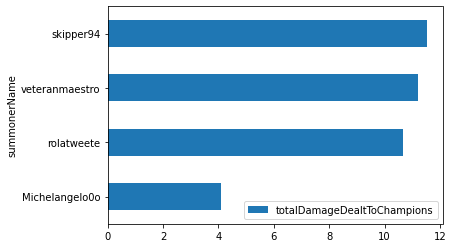

In [21]:
pd.pivot_table(data=summoner_avg_stats_df, values=['totalDamageDealtToChampions'],index='summonerName').sort_values(by='totalDamageDealtToChampions',ascending=True).plot(kind='barh')

<AxesSubplot:ylabel='summonerName'>

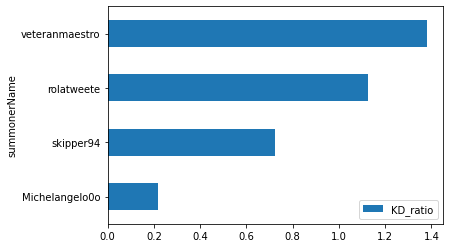

In [22]:
pd.pivot_table(data=summoner_avg_stats_df, values=['KD_ratio'],index='summonerName').sort_values(by='KD_ratio',ascending=True).plot(kind='barh')

<AxesSubplot:ylabel='summonerName'>

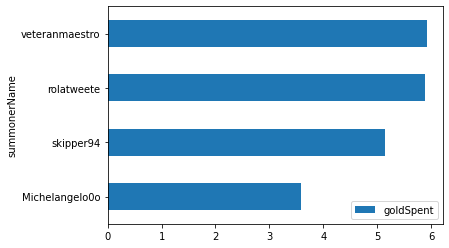

In [23]:
pd.pivot_table(data=summoner_avg_stats_df, values=['goldSpent'],index='summonerName').sort_values(by='goldSpent',ascending=True).plot(kind='barh')

<AxesSubplot:ylabel='summonerName'>

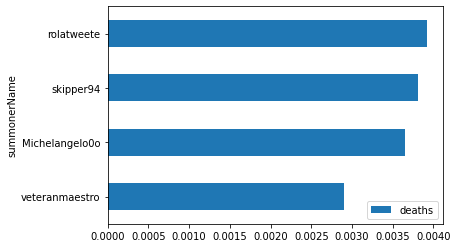

In [24]:
pd.pivot_table(data=summoner_avg_stats_df, values=['deaths'],index='summonerName').sort_values(by='deaths',ascending=True).plot(kind='barh')

<AxesSubplot:ylabel='summonerName'>

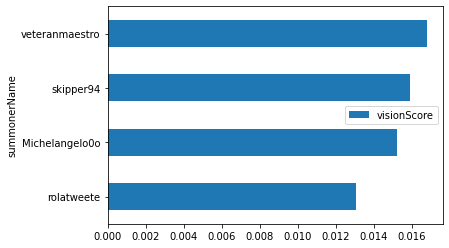

In [25]:
pd.pivot_table(data=summoner_avg_stats_df, values=['visionScore'],index='summonerName').sort_values(by='visionScore',ascending=True).plot(kind='barh')

<AxesSubplot:ylabel='summonerName'>

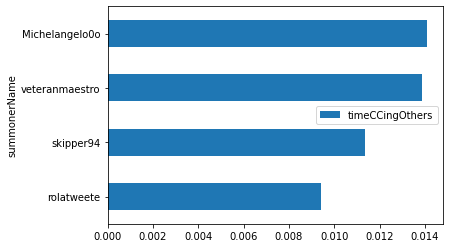

In [26]:
pd.pivot_table(data=summoner_avg_stats_df, values=['timeCCingOthers'],index='summonerName').sort_values(by='timeCCingOthers',ascending=True).plot(kind='barh')

<AxesSubplot:ylabel='summonerName'>

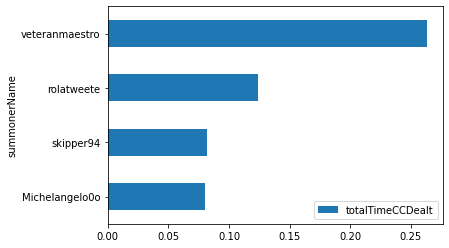

In [27]:
pd.pivot_table(data=summoner_avg_stats_df, values=['totalTimeCCDealt'],index='summonerName').sort_values(by='totalTimeCCDealt',ascending=True).plot(kind='barh')

<AxesSubplot:ylabel='summonerName'>

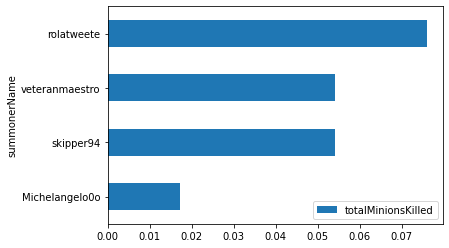

In [28]:
pd.pivot_table(data=summoner_avg_stats_df, values=['totalMinionsKilled'],index='summonerName').sort_values(by='totalMinionsKilled',ascending=True).plot(kind='barh')

<AxesSubplot:ylabel='summonerName'>

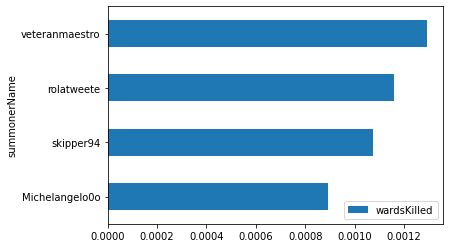

In [30]:
pd.pivot_table(data=summoner_avg_stats_df, values=['wardsKilled'],index='summonerName').sort_values(by='wardsKilled',ascending=True).plot(kind='barh')

<AxesSubplot:ylabel='summonerName'>

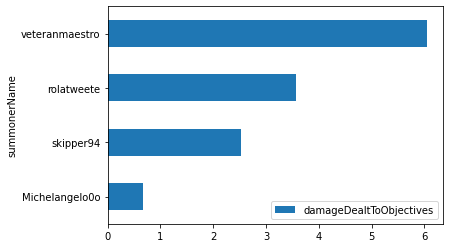

In [31]:
pd.pivot_table(data=summoner_avg_stats_df, values=['damageDealtToObjectives'],index='summonerName').sort_values(by='damageDealtToObjectives',ascending=True).plot(kind='barh')

<AxesSubplot:ylabel='summonerName'>

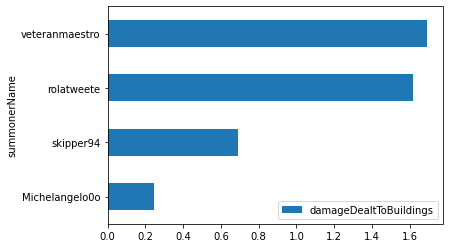

In [32]:
pd.pivot_table(data=summoner_avg_stats_df, values=['damageDealtToBuildings'],index='summonerName').sort_values(by='damageDealtToBuildings',ascending=True).plot(kind='barh')

<AxesSubplot:ylabel='summonerName'>

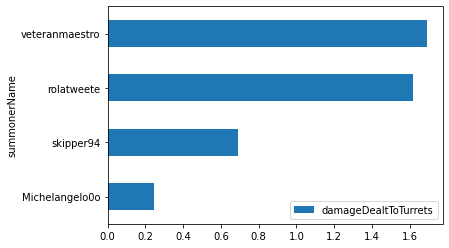

In [33]:
pd.pivot_table(data=summoner_avg_stats_df, values=['damageDealtToTurrets'],index='summonerName').sort_values(by='damageDealtToTurrets',ascending=True).plot(kind='barh')

<AxesSubplot:ylabel='summonerName'>

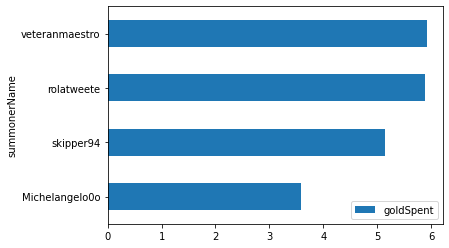

In [34]:
pd.pivot_table(data=summoner_avg_stats_df, values=['goldSpent'],index='summonerName').sort_values(by='goldSpent',ascending=True).plot(kind='barh')

<AxesSubplot:ylabel='summonerName'>

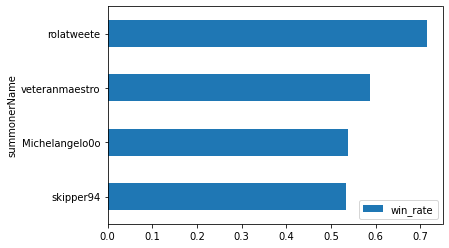

In [35]:
pd.pivot_table(data=summoner_avg_stats_df, values=['win_rate'],index='summonerName').sort_values(by='win_rate',ascending=True).plot(kind='barh')